Hypothesis: the model optimizations (force-consider; graph-normalization; and both) do not affect the payoff of the optimal policy

Fact: The policy itself is affected as state and action spaces are not the same after applying the optimizations.

Plan: Take the models with fixed exploration depth, solve MDPs compare results.

In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("4-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,depth,size,time_spent,rss,mdp
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,4,35,0.129976,0.108158,1c2c46a1
1,baseline,generic_1,False,False,True,True,False,bitcoin,4,4135,2.487872,0.336849,141eff95
2,baseline,generic_1,False,False,True,True,False,ethereum_3,4,12625,13.329758,0.363773,64fb1741
3,baseline,generic_1,False,False,True,True,False,byzantium_3,4,12627,13.081303,0.365273,a1cb7802
4,baseline,generic_1,False,False,True,True,False,ghostdag_3,4,18128,29.605227,0.368526,4fd68bfe
5,baseline,generic_1,False,False,True,True,False,parallel_3,4,44955,30.925288,0.600632,2f7eab99
6,w/ force consider,generic_1,True,False,True,True,False,bitcoin,4,879,5.126831,0.373436,1714d09b
7,w/ force consider,generic_1,True,False,True,True,False,ethereum_3,4,8437,13.274809,0.374485,23620768
8,w/ force consider,generic_1,True,False,True,True,False,byzantium_3,4,8341,14.462211,0.377777,449793eb
9,w/ force consider,generic_1,True,False,True,True,False,ghostdag_3,4,2671,9.667219,0.376793,79bc8b2d


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                _episode_reward_per_progress=episode_reward
                / episode_progress,  # progress is already accounted for via ptmdp/horizon
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("4-value-iterations.pkl.gz")
df

  0%|                                                                                                  | 0/84 [00:00<?, ?it/s]

  1%|█                                                                                         | 1/84 [00:00<00:10,  8.28it/s]

  2%|██▏                                                                                       | 2/84 [00:13<11:11,  8.19s/it]

  4%|███▏                                                                                      | 3/84 [01:07<39:04, 28.95s/it]

  5%|████▎                                                                                     | 4/84 [01:50<45:52, 34.41s/it]

  6%|█████▎                                                                                    | 5/84 [02:49<56:56, 43.25s/it]

  7%|██████▎                                                                                 | 6/84 [05:37<1:51:34, 85.82s/it]

  8%|███████▎                                                                                | 7/84 [05:41<1:15:42, 58.99s/it]

 10%|████████▍                                                                               | 8/84 [06:21<1:07:12, 53.06s/it]

 11%|█████████▋                                                                                | 9/84 [06:55<58:36, 46.89s/it]

 12%|██████████▌                                                                              | 10/84 [07:04<43:20, 35.14s/it]

 13%|███████████▋                                                                             | 11/84 [07:46<45:30, 37.41s/it]

 14%|████████████▋                                                                            | 12/84 [08:02<37:02, 30.87s/it]

 15%|█████████████▍                                                                         | 13/84 [11:59<1:50:32, 93.41s/it]

 17%|██████████████▎                                                                       | 14/84 [15:09<2:22:51, 122.44s/it]

 18%|███████████████▌                                                                       | 15/84 [15:39<1:48:43, 94.55s/it]

 19%|████████████████▌                                                                      | 16/84 [17:07<1:45:04, 92.72s/it]

 20%|█████████████████▌                                                                     | 17/84 [17:09<1:12:55, 65.30s/it]

 21%|███████████████████                                                                      | 18/84 [17:19<53:33, 48.69s/it]

 23%|████████████████████▏                                                                    | 19/84 [17:27<39:34, 36.53s/it]

 24%|█████████████████████▏                                                                   | 20/84 [17:30<28:13, 26.47s/it]

 25%|██████████████████████▎                                                                  | 21/84 [17:42<23:21, 22.24s/it]

 26%|███████████████████████▎                                                                 | 22/84 [17:43<16:07, 15.61s/it]

 27%|████████████████████████▎                                                                | 23/84 [17:58<15:57, 15.70s/it]

 29%|█████████████████████████▍                                                               | 24/84 [18:53<27:21, 27.35s/it]

 30%|██████████████████████████▍                                                              | 25/84 [19:41<32:55, 33.48s/it]

 31%|███████████████████████████▌                                                             | 26/84 [20:42<40:27, 41.85s/it]

 32%|███████████████████████████▉                                                           | 27/84 [23:41<1:18:51, 83.00s/it]

 33%|█████████████████████████████▋                                                           | 28/84 [23:46<55:28, 59.43s/it]

 35%|██████████████████████████████▋                                                          | 29/84 [24:27<49:29, 53.99s/it]

 36%|███████████████████████████████▊                                                         | 30/84 [25:02<43:34, 48.42s/it]

 37%|████████████████████████████████▊                                                        | 31/84 [25:12<32:27, 36.75s/it]

 38%|█████████████████████████████████▉                                                       | 32/84 [25:57<33:56, 39.16s/it]

 39%|██████████████████████████████████▉                                                      | 33/84 [26:15<27:55, 32.85s/it]

 40%|███████████████████████████████████▏                                                   | 34/84 [30:14<1:19:04, 94.90s/it]

 42%|███████████████████████████████████▊                                                  | 35/84 [33:44<1:45:33, 129.25s/it]

 43%|█████████████████████████████████████▎                                                 | 36/84 [34:14<1:19:34, 99.47s/it]

 44%|██████████████████████████████████████▎                                                | 37/84 [35:46<1:16:10, 97.24s/it]

 45%|████████████████████████████████████████▎                                                | 38/84 [35:48<52:34, 68.58s/it]

 46%|█████████████████████████████████████████▎                                               | 39/84 [35:58<38:21, 51.16s/it]

 48%|██████████████████████████████████████████▍                                              | 40/84 [36:07<28:13, 38.50s/it]

 49%|███████████████████████████████████████████▍                                             | 41/84 [36:10<19:56, 27.84s/it]

 50%|████████████████████████████████████████████▌                                            | 42/84 [36:23<16:18, 23.29s/it]

 51%|█████████████████████████████████████████████▌                                           | 43/84 [36:23<11:10, 16.35s/it]

 52%|██████████████████████████████████████████████▌                                          | 44/84 [36:38<10:40, 16.02s/it]

 54%|███████████████████████████████████████████████▋                                         | 45/84 [37:38<18:54, 29.10s/it]

 55%|████████████████████████████████████████████████▋                                        | 46/84 [38:25<21:55, 34.62s/it]

 56%|█████████████████████████████████████████████████▊                                       | 47/84 [39:28<26:34, 43.08s/it]

 57%|██████████████████████████████████████████████████▊                                      | 48/84 [42:30<50:48, 84.68s/it]

 58%|███████████████████████████████████████████████████▉                                     | 49/84 [42:34<35:19, 60.55s/it]

 60%|████████████████████████████████████████████████████▉                                    | 50/84 [43:17<31:24, 55.42s/it]

 61%|██████████████████████████████████████████████████████                                   | 51/84 [43:55<27:32, 50.07s/it]

 62%|███████████████████████████████████████████████████████                                  | 52/84 [44:04<20:10, 37.81s/it]

 63%|████████████████████████████████████████████████████████▏                                | 53/84 [44:52<21:06, 40.85s/it]

 64%|█████████████████████████████████████████████████████████▏                               | 54/84 [45:09<16:53, 33.77s/it]

 65%|█████████████████████████████████████████████████████████▌                              | 55/84 [49:28<48:54, 101.20s/it]

 67%|█████████████████████████████████████████████████████████▎                            | 56/84 [52:58<1:02:24, 133.74s/it]

 68%|███████████████████████████████████████████████████████████▋                            | 57/84 [53:29<46:19, 102.93s/it]

 69%|████████████████████████████████████████████████████████████▊                           | 58/84 [55:02<43:23, 100.12s/it]

 70%|██████████████████████████████████████████████████████████████▌                          | 59/84 [55:04<29:23, 70.55s/it]

 71%|███████████████████████████████████████████████████████████████▌                         | 60/84 [55:15<21:02, 52.60s/it]

 73%|████████████████████████████████████████████████████████████████▋                        | 61/84 [55:23<15:08, 39.48s/it]

 74%|█████████████████████████████████████████████████████████████████▋                       | 62/84 [55:26<10:28, 28.55s/it]

 75%|██████████████████████████████████████████████████████████████████▊                      | 63/84 [55:40<08:23, 23.97s/it]

 76%|███████████████████████████████████████████████████████████████████▊                     | 64/84 [55:40<05:36, 16.82s/it]

 77%|████████████████████████████████████████████████████████████████████▊                    | 65/84 [55:57<05:23, 17.02s/it]

 79%|█████████████████████████████████████████████████████████████████████▉                   | 66/84 [56:58<09:04, 30.26s/it]

 80%|██████████████████████████████████████████████████████████████████████▉                  | 67/84 [57:50<10:22, 36.59s/it]

 81%|████████████████████████████████████████████████████████████████████████                 | 68/84 [58:54<11:59, 44.99s/it]

 82%|███████████████████████████████████████████████████████████████████████▍               | 69/84 [1:02:04<22:04, 88.32s/it]

 83%|████████████████████████████████████████████████████████████████████████▌              | 70/84 [1:02:09<14:46, 63.31s/it]

 85%|█████████████████████████████████████████████████████████████████████████▌             | 71/84 [1:02:53<12:28, 57.57s/it]

 86%|██████████████████████████████████████████████████████████████████████████▌            | 72/84 [1:03:30<10:17, 51.46s/it]

 87%|███████████████████████████████████████████████████████████████████████████▌           | 73/84 [1:03:39<07:06, 38.81s/it]

 88%|████████████████████████████████████████████████████████████████████████████▋          | 74/84 [1:04:28<06:58, 41.80s/it]

 89%|█████████████████████████████████████████████████████████████████████████████▋         | 75/84 [1:04:48<05:17, 35.27s/it]

 90%|█████████████████████████████████████████████████████████████████████████████▊        | 76/84 [1:09:08<13:39, 102.45s/it]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 77/84 [1:12:52<16:13, 139.01s/it]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 78/84 [1:13:26<10:44, 107.45s/it]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 79/84 [1:15:06<08:46, 105.33s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▊    | 80/84 [1:15:08<04:57, 74.27s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▉   | 81/84 [1:15:19<02:45, 55.23s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 82/84 [1:15:28<01:22, 41.49s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 83/84 [1:15:31<00:29, 29.95s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 84/84 [1:15:45<00:00, 25.01s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 84/84 [1:15:45<00:00, 54.11s/it]

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,depth,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,_episode_reward_per_progress
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,4,35,...,0.33,1,0.000992,0.001,710,0,0.119401,37.062782,98.474043,0.376371
1,baseline,generic_1,False,False,True,True,False,bitcoin,4,4135,...,0.33,1,0.000999,0.001,1433,0,13.734992,37.048181,98.266676,0.377017
2,baseline,generic_1,False,False,True,True,False,ethereum_3,4,12625,...,0.33,1,0.000998,0.001,1698,0,53.212732,49.264375,98.344405,0.500937
3,baseline,generic_1,False,False,True,True,False,byzantium_3,4,12627,...,0.33,1,0.000997,0.001,1340,0,42.433879,35.977282,98.168578,0.366485
4,baseline,generic_1,False,False,True,True,False,ghostdag_3,4,18128,...,0.33,1,0.001000,0.001,1186,0,58.330700,34.549552,98.086075,0.352237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,w/ both,generic_1,True,True,True,True,False,bitcoin,4,320,...,0.66,1,0.000999,0.001,1763,0,1.779139,52.932112,98.755628,0.535991
80,w/ both,generic_1,True,True,True,True,False,ethereum_3,4,2112,...,0.66,1,0.000999,0.001,1723,0,10.769917,55.426433,98.746349,0.561301
81,w/ both,generic_1,True,True,True,True,False,byzantium_3,4,2082,...,0.66,1,0.000997,0.001,1477,0,9.336988,47.221886,98.573023,0.479055
82,w/ both,generic_1,True,True,True,True,False,ghostdag_3,4,828,...,0.66,1,0.000999,0.001,1163,0,2.996346,39.726048,98.202938,0.404530


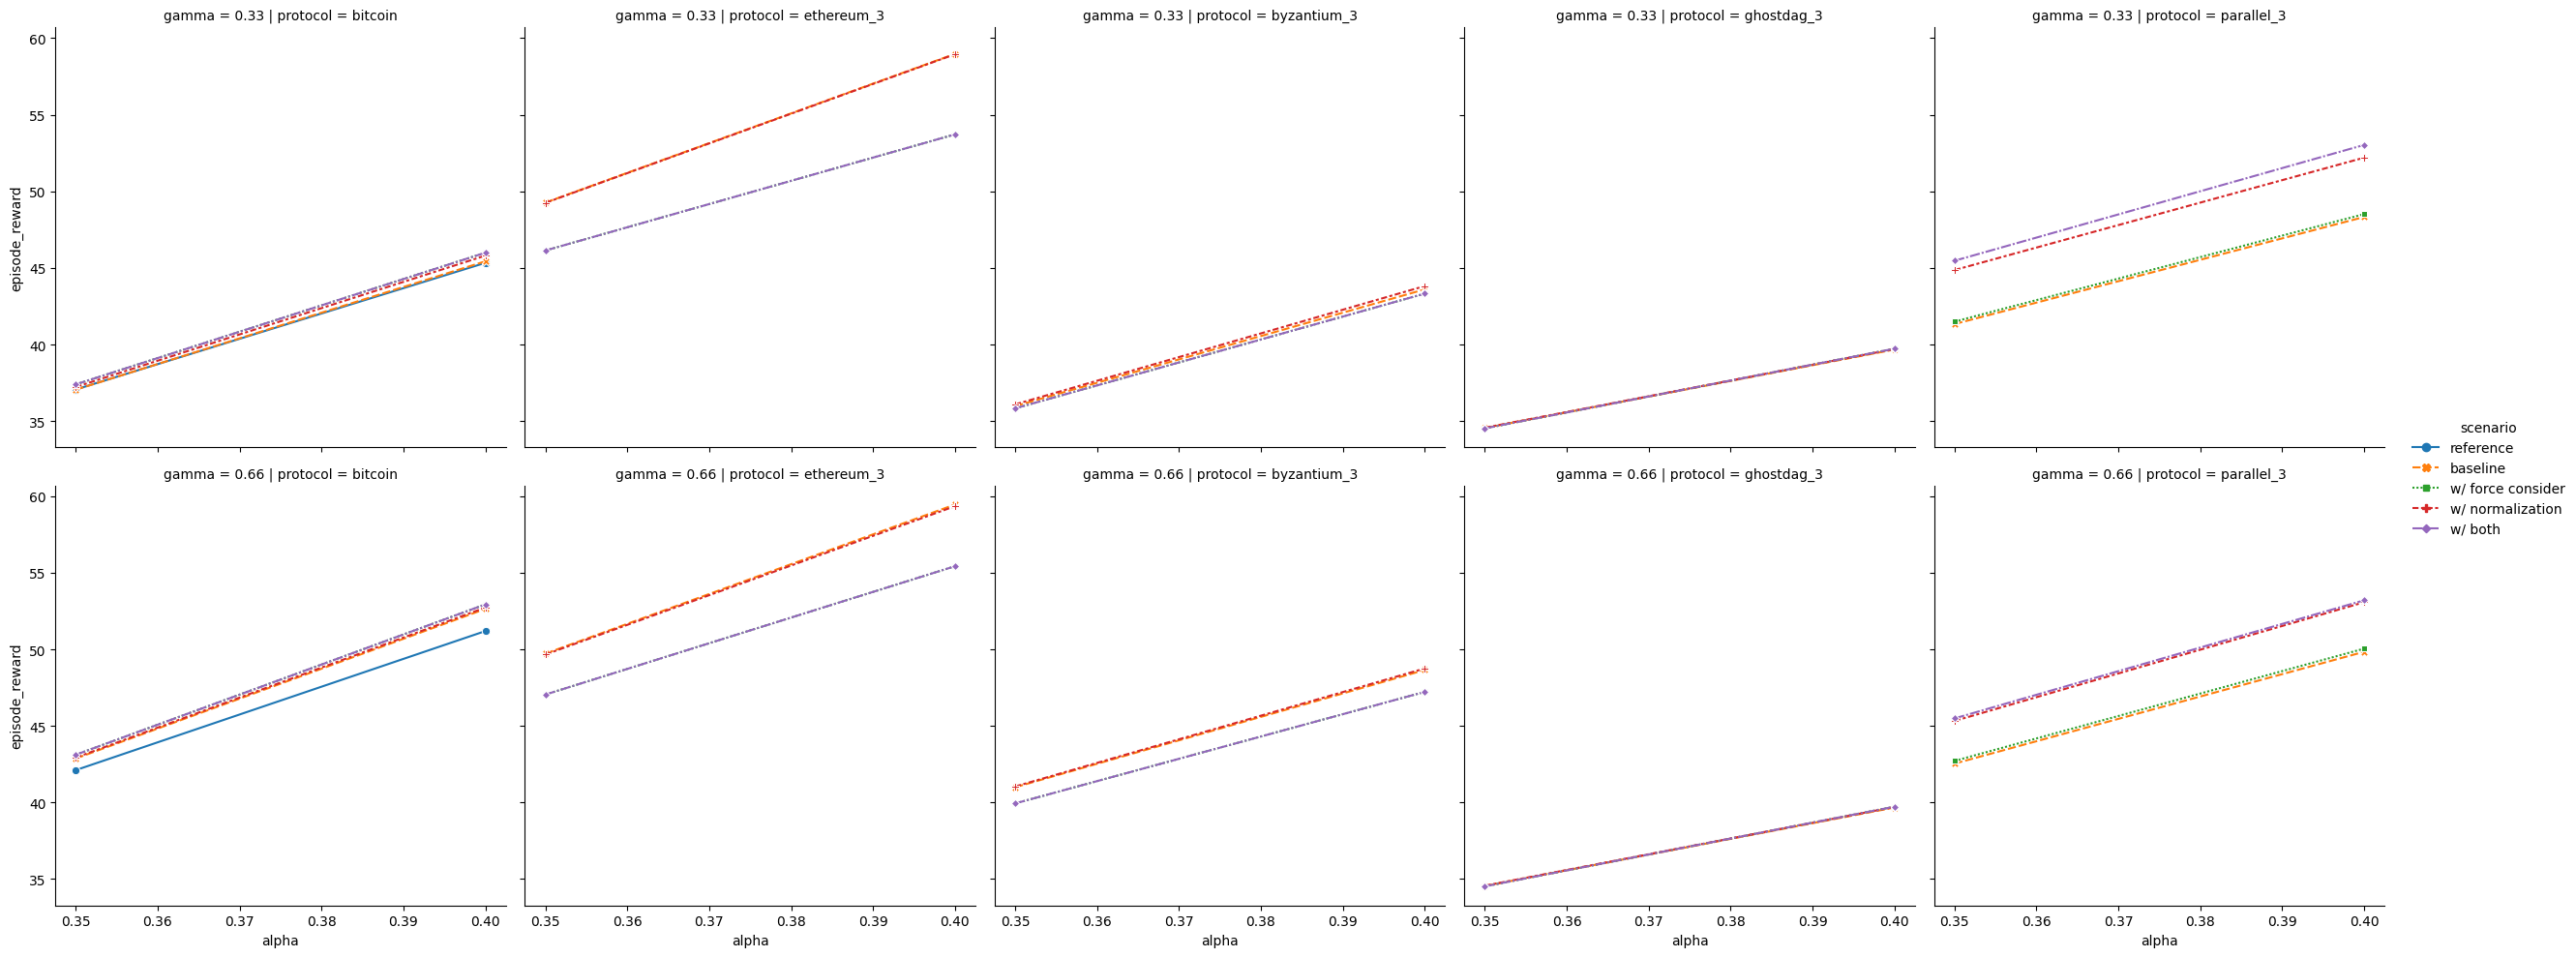

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

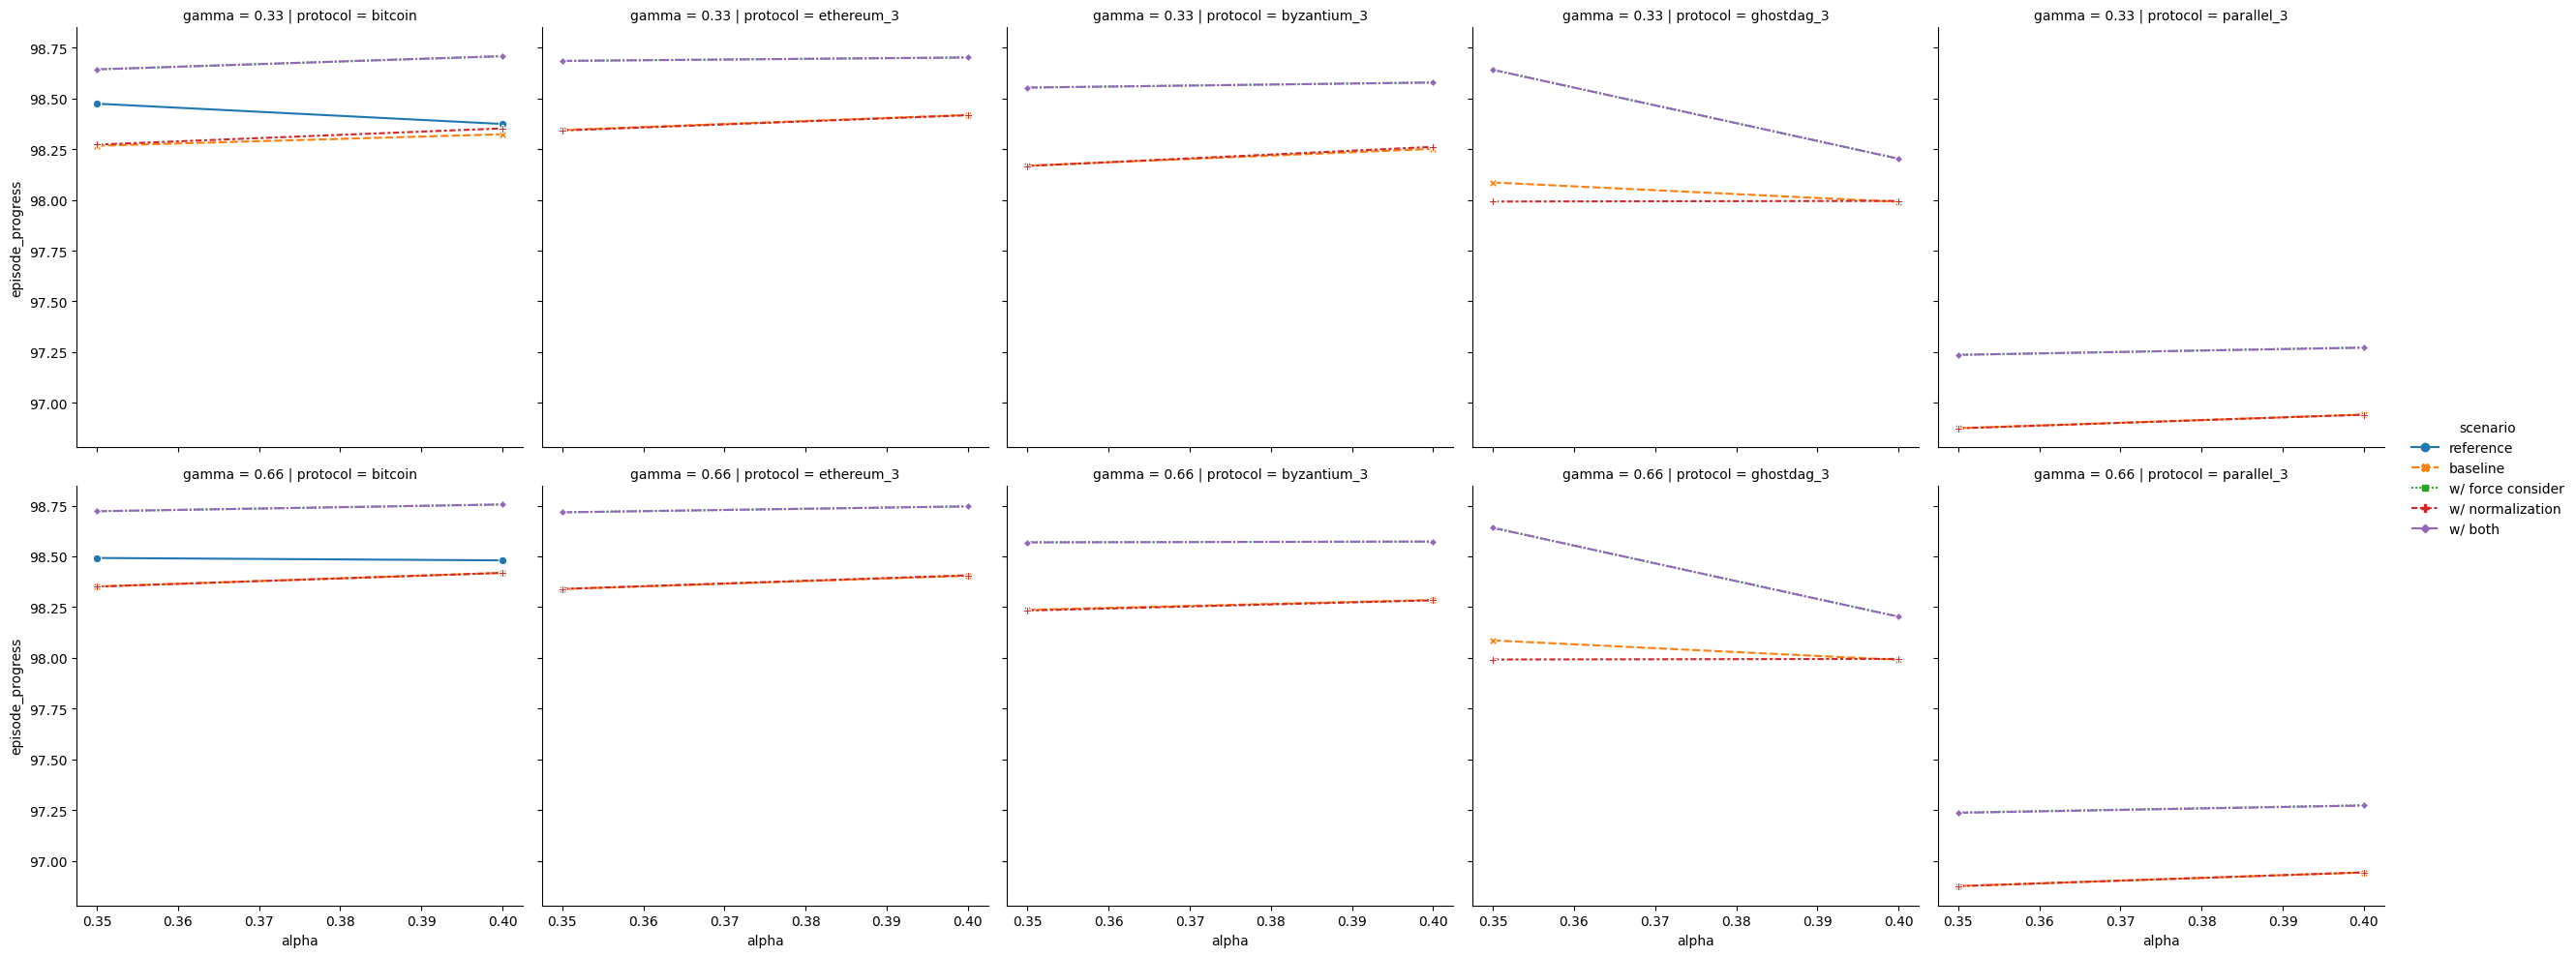

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

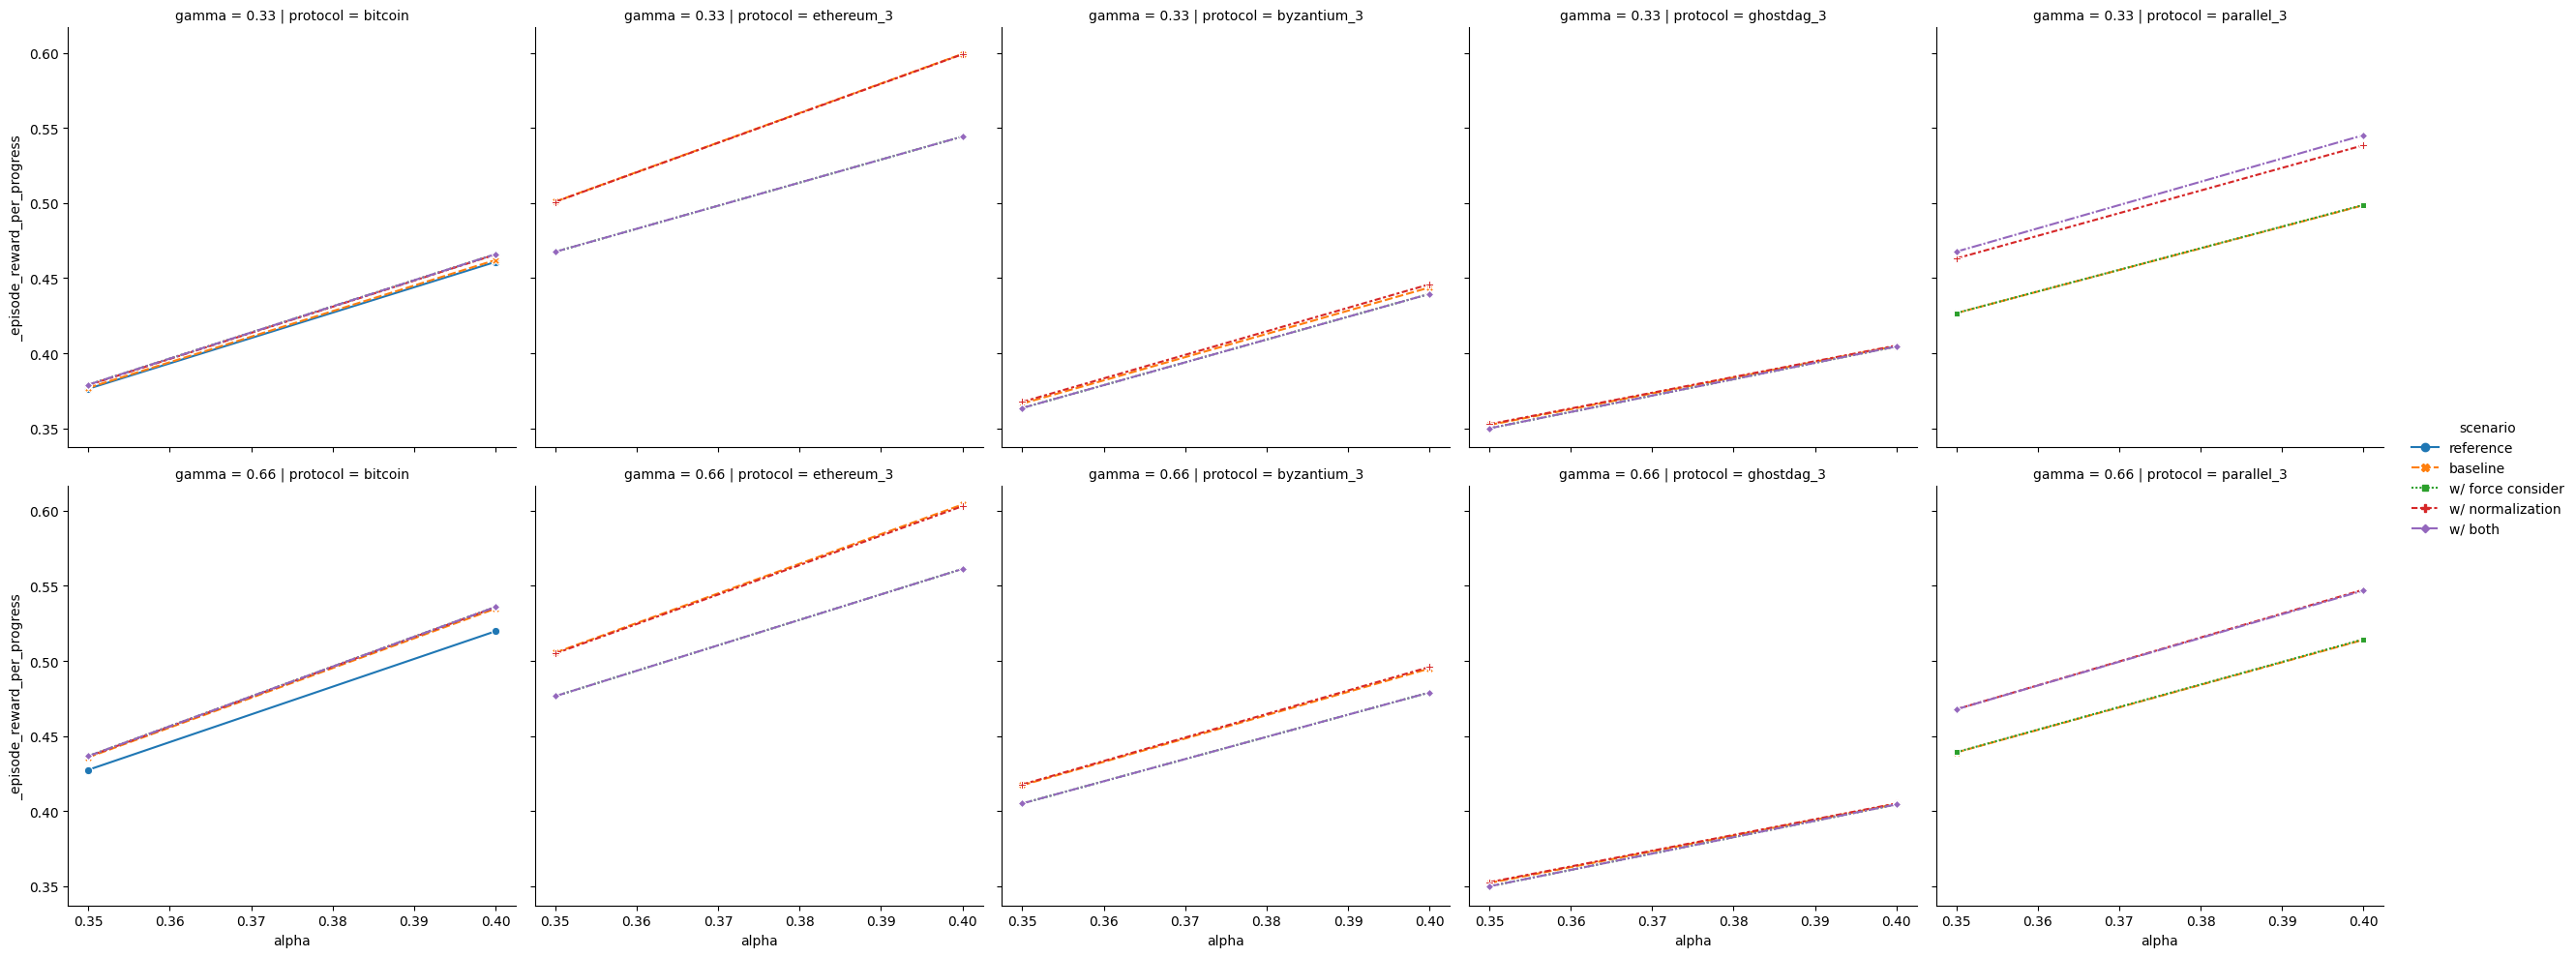

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="_episode_reward_per_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

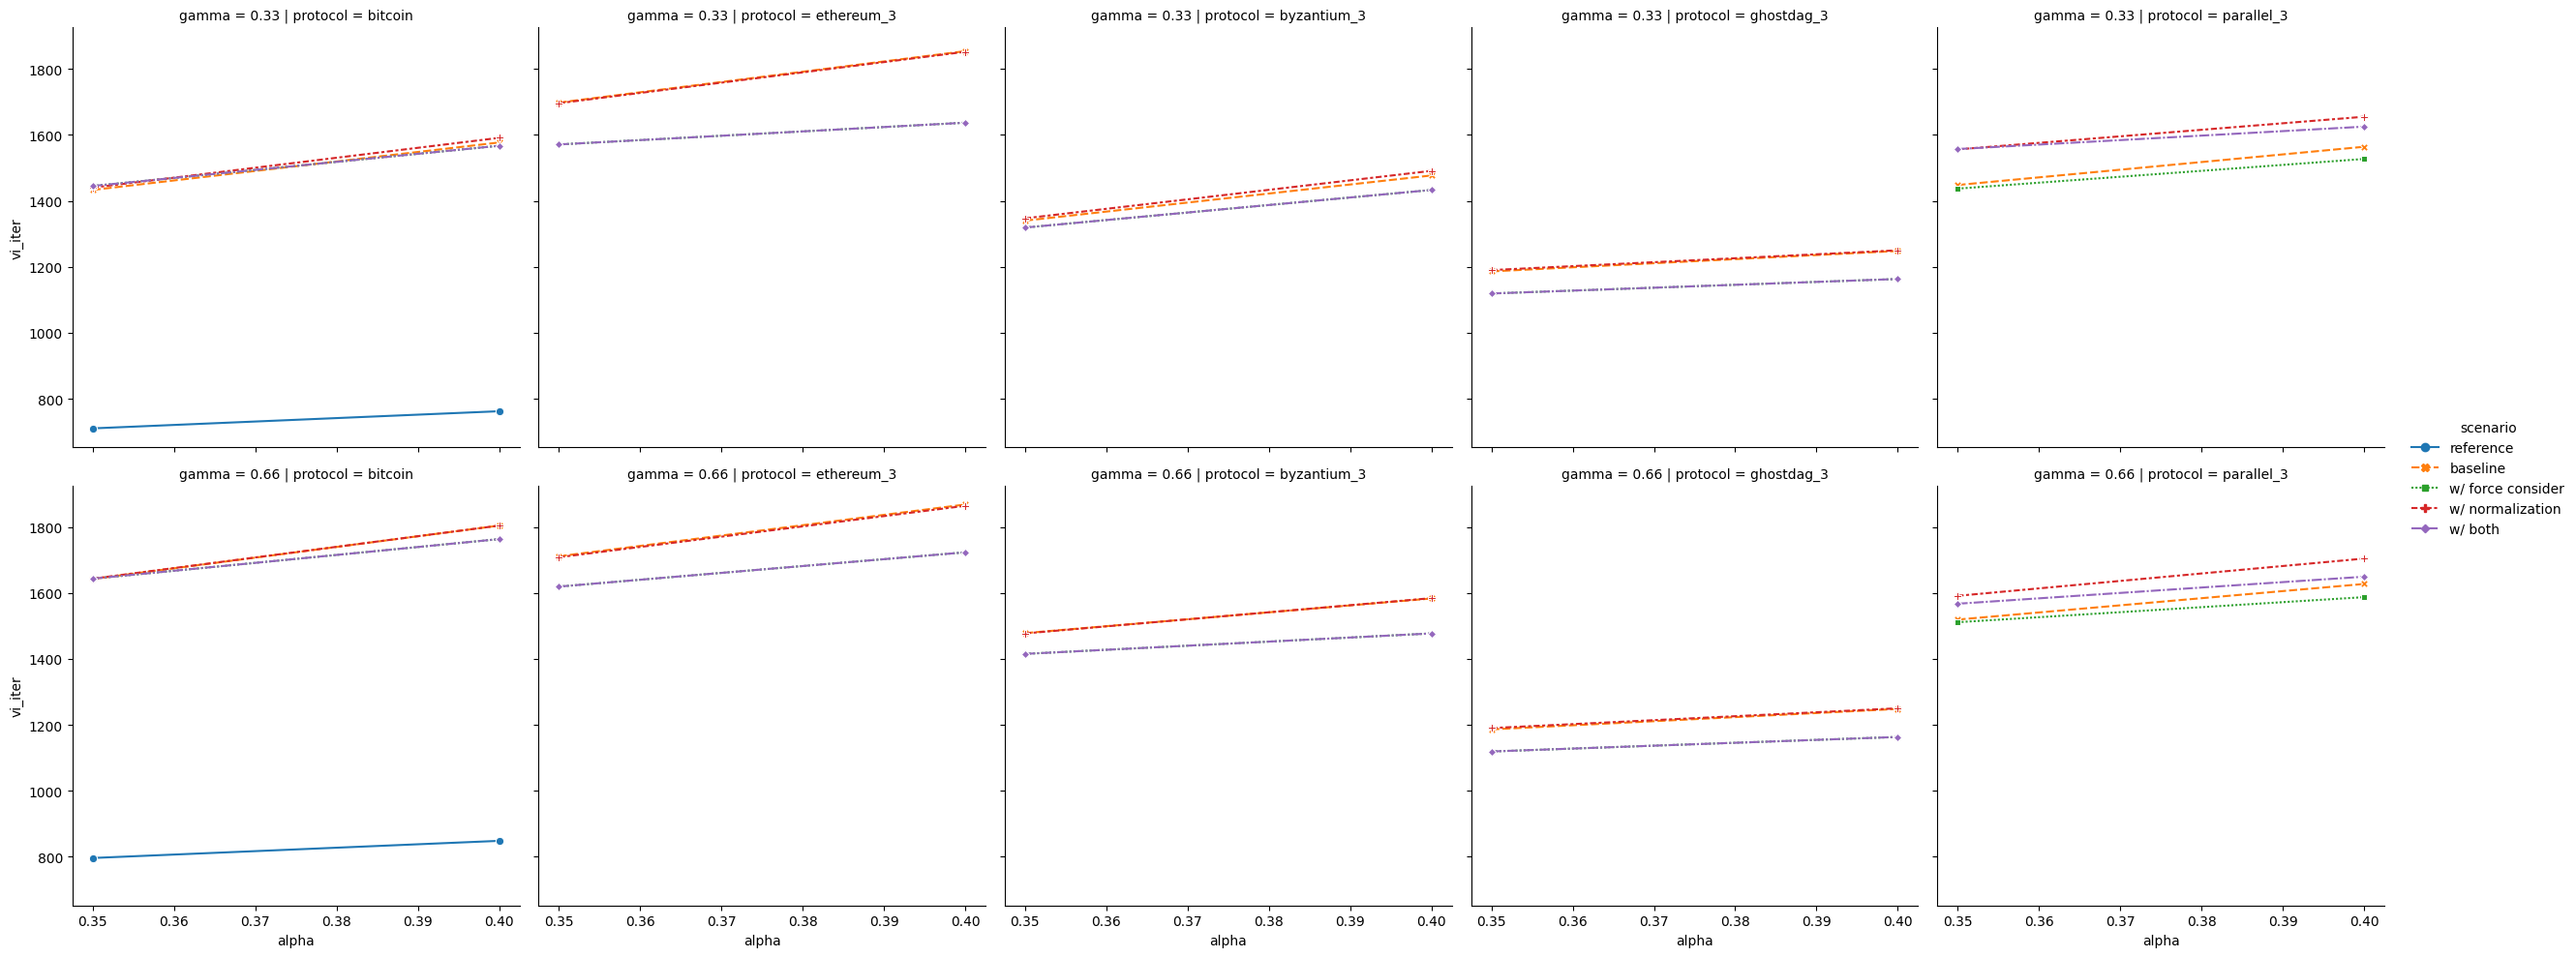

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

# Stop condition for value iteration

An *approved* stop condition for $\varepsilon$-optimal policy with `discount` factor:

```python
stop_delta = eps * ( 1 - discount ) / discount
```

Now, what is our discount factor? We're discounting for progress (PT MDP) and depending on the horizon.
The termination probability for horizon `H` and progress `Dt` is:

```python
term_prob = 1.0 - ((1.0 - (1.0 / H)) ** Dt)
```

I think our termination probability is somewhat similar to `(1 - discount)` in the infinite horizon value iteration. **(can it?)**

Let's tabulate this to get a feeling

In [9]:
H = 10
Dt = range(0, 4)
term_prob = [1.0 - ((1.0 - (1.0 / H)) ** p) for p in Dt]
pseudo_discount = [1 - tp for tp in term_prob]
[(1 - discount) / discount for discount in pseudo_discount]  # stop_delta / eps

[0.0, 0.11111111111111108, 0.23456790123456783, 0.37174211248285305]

So the smallest progress drives the stop delta. That's cool, because I think the smallest non-zero progress should be one in all protocols. **(checked below)**.

What is our $\varepsilon$?

The horizon scales the expected reward linearly. Max reward equals horizon. If we increase the horizon we can also increase the epsilon to stay at the same precision.

In [10]:
digits_precision = 3
H = [10, 100, 1000]
eps = [h / (10**digits_precision) for h in H]
eps

[0.01, 0.1, 1.0]

In [11]:
def stop_delta(horizon, digits_precision, min_progress=1):
    tp = 1.0 - ((1.0 - (1.0 / horizon)) ** min_progress)
    pd = 1 - tp
    eps = horizon / (10**digits_precision)
    return eps * (1 - pd) / pd


[stop_delta(h, 3) for h in [10, 100, 1000]]

[0.001111111111111111, 0.001010101010101011, 0.0010010010010010019]

So, no matter how we scale the horizon, the stop delta can be around 0.001 if we want 3 digit precision.

Now, it seems the observed errors above are _much_ higher.

# Minimum progress

The above assumes `min_progess = 1`. Let's see whether this is true.

In [12]:
rows = []
for i, row in mdps.iterrows():
    with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)

    min_prg = 10000
    min_prg_nonzero = 10000
    max_prg = 0
    for state_actions in emdp.tab:
        for action_transitions in state_actions:
            for transition in action_transitions:
                min_prg = min(min_prg, transition.progress)
                max_prg = max(max_prg, transition.progress)
                if transition.progress > 0:
                    min_prg_nonzero = min(min_prg_nonzero, transition.progress)

    rows.append(
        row.to_dict()
        | dict(max_prg=max_prg, min_prg=min_prg, min_prg_nonzero=min_prg_nonzero)
    )

prg_check = pandas.DataFrame(rows)
assert prg_check.min_prg.min() >= 0
assert prg_check.min_prg_nonzero.min() >= 1